<a href="https://colab.research.google.com/github/romaniuk-o/Python_Data_Science_HW6/blob/main/HW_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=c9b6166c9e5368a54bf632932ab44fb4b049f0af60e3863d184161caa22dafb7
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [32]:
import random
import pyspark
from pyspark.sql import SparkSession, functions as f
from matplotlib import pyplot as plt
import seaborn as sns


### **Завдання 1**

У цьому завданні вам потрібно завантажити ось цей датасет. Ми з вами вже працювали з ним коли вивчали pandas. Це все також Топ-50 книг, що найбільше продаються на Amazon в період з 2009 по 2019 роки. Потрібно виконати наступне:

Створити спарк сесію.

In [4]:
spark_session = SparkSession.builder.getOrCreate()

Прочитати датасет в датафрейм.

In [7]:
df = spark_session.read.csv("bestsellers_with _categories.csv",header=True, inferSchema=True)
df.show()

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|        4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|        4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|


Використовуючи тільки RDD, обчислити середню ціну всіх книг, у яких рейтинг вищий за 4.7


In [8]:
df2 = df.alias('df')
df3 = df2.withColumnRenamed("User Rating", "user_rating")



df4 = (df3.filter(f.col('user_rating') > 4.7)).agg({'Price':'mean'}).show()

+-----------------+
|       avg(Price)|
+-----------------+
|10.69832402234637|
+-----------------+



Побудувати гістограму розподілу рецензій (стовпчик Reviews).

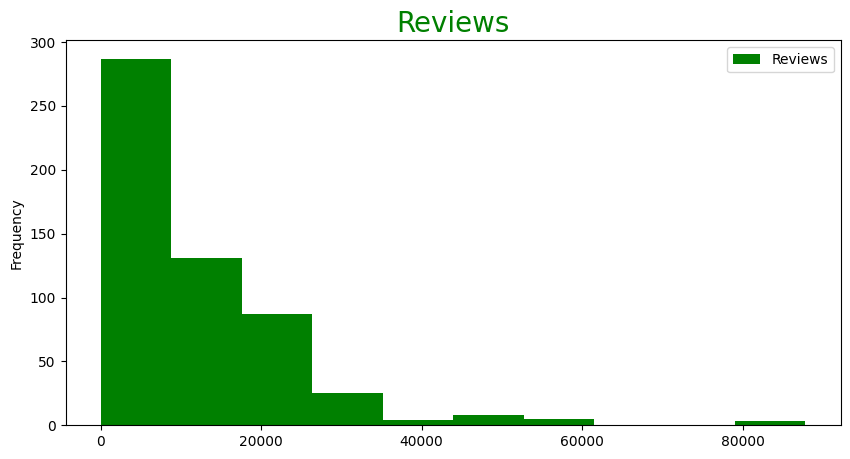

In [9]:
df5 = df3['Author','Reviews'].toPandas()
df5['Reviews'] = df5[['Reviews']].astype(float)
df5.plot.hist(y='Reviews',color='g', figsize=(10, 5), bins=10)
plt.title('Reviews', fontsize=20, color='g')
plt.show()

Побудувати матрицю кореляції для стовпців "User Rating", "Reviews" та "Price".

In [10]:
df6 = df3['user_rating', 'Reviews', 'Price'].toPandas()
df6.corr()    

     

,user_rating,Reviews,Price
user_rating,1.000000,-0.001729,-0.133086
Reviews,-0.001729,1.000000,-0.109182
Price,-0.133086,-0.109182,1.000000


Використовуючи бібліотеку seaborn, побудувати парні графіки (pairplots) стовпців "User Rating", "Reviews" та "Price".

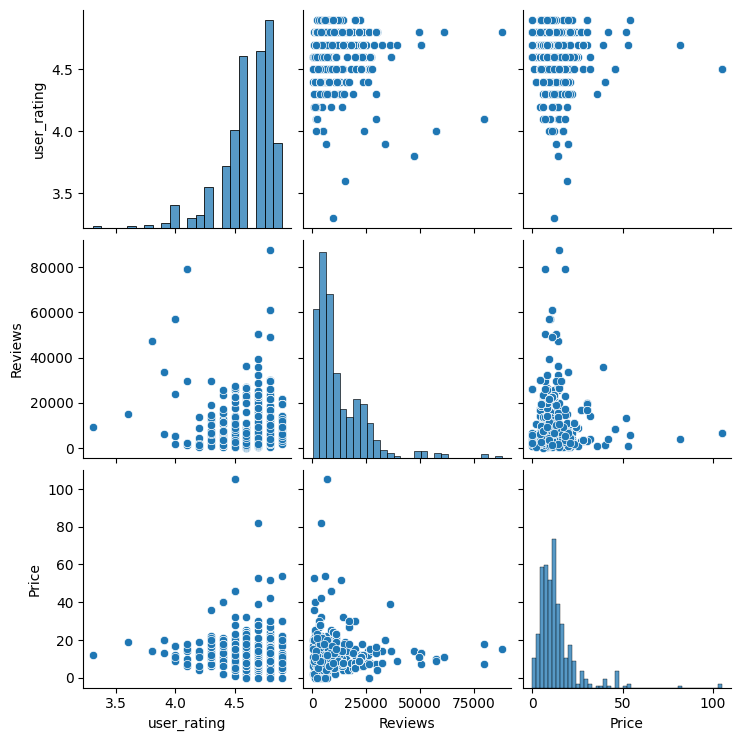

In [11]:
sns.pairplot(df6);

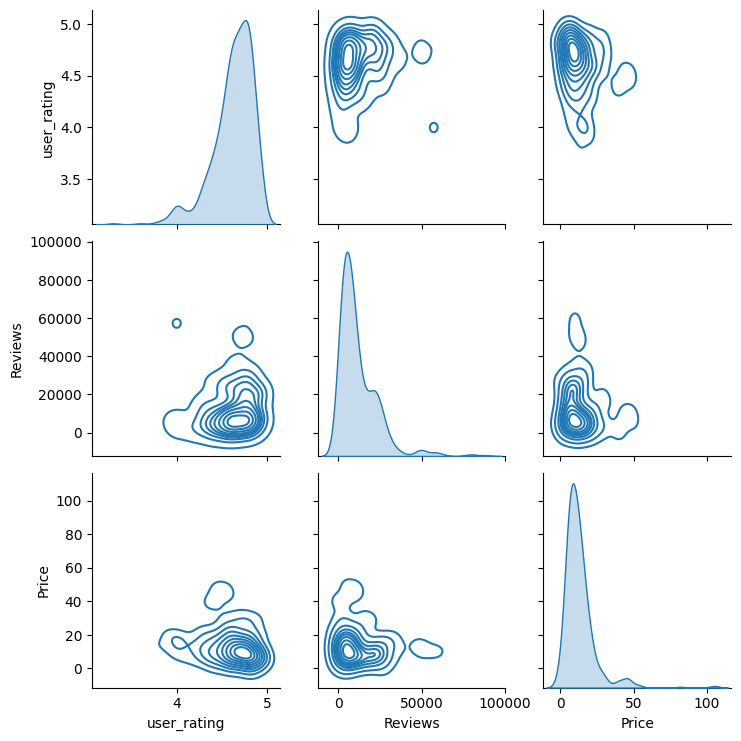

In [12]:
sns.pairplot(df6, kind="kde");

### **Завдання 2**

Під час виконання цього завдання дозволяється використовувати лише Spark SQL. Для датасету з попереднього завдання виконайте наступне:


Знайдіть автора з найвищим рейтингом.

In [13]:
df3.createOrReplaceTempView("sql_table")

In [14]:
spark_session.sql("SELECT DISTINCT Author, Author FROM sql_table WHERE Author == (SELECT MAX(user_rating) FROM sql_table)").show()

+------+------+
|Author|Author|
+------+------+
+------+------+



Знайдіть трьох авторів із найнижчим рейтингом.

In [15]:
spark_session.sql("SELECT DISTINCT Author, user_rating FROM sql_table ORDER BY user_rating LIMIT 3").show()

+------------+-----------+
|      Author|user_rating|
+------------+-----------+
|J.K. Rowling|        3.3|
|  Harper Lee|        3.6|
|   E L James|        3.8|
+------------+-----------+



Визначте, який автор отримав найбільшу кількість рецензій.

In [16]:
spark_session.sql("SELECT DISTINCT Author, Reviews FROM sql_table WHERE Reviews == (SELECT MAX(Reviews) FROM sql_table)").show()

+-----------+-------+
|     Author|Reviews|
+-----------+-------+
|Delia Owens|  87841|
+-----------+-------+



Визначте, який автор написав найбільшу кількість книг за весь доступний у даних період.

In [17]:
spark_session.sql("SELECT Author, number FROM (SELECT Author, COUNT(Author) as number FROM sql_table GROUP BY Author) ORDER BY number DESC LIMIT 1").show()

+-----------+------+
|     Author|number|
+-----------+------+
|Jeff Kinney|    12|
+-----------+------+



Визначте, яка книга жанру "Fiction" має найменший рейтинг.

In [18]:

spark_session.sql("SELECT Name, Genre, User_Rating FROM sql_table WHERE Genre='Fiction' ORDER BY User_Rating LIMIT 1").show()

+------------------+-------+-----------+
|              Name|  Genre|User_Rating|
+------------------+-------+-----------+
|The Casual Vacancy|Fiction|        3.3|
+------------------+-------+-----------+



Визначте, яка книга жанру "Non Fiction" має найвищий рейтинг.

In [19]:
spark_session.sql("SELECT Name, Genre, User_Rating FROM sql_table WHERE Genre='Non Fiction' AND user_rating = (SELECT MAX(user_rating) FROM sql_table)").show()

+--------------------+-----------+-----------+
|                Name|      Genre|User_Rating|
+--------------------+-----------+-----------+
|Hamilton: The Rev...|Non Fiction|        4.9|
|Humans of New Yor...|Non Fiction|        4.9|
|Jesus Calling: En...|Non Fiction|        4.9|
|Jesus Calling: En...|Non Fiction|        4.9|
|Jesus Calling: En...|Non Fiction|        4.9|
|Jesus Calling: En...|Non Fiction|        4.9|
|Jesus Calling: En...|Non Fiction|        4.9|
|Jesus Calling: En...|Non Fiction|        4.9|
|Obama: An Intimat...|Non Fiction|        4.9|
|  The Magnolia Story|Non Fiction|        4.9|
|Unfreedom of the ...|Non Fiction|        4.9|
+--------------------+-----------+-----------+



### **Завдання 3**

Побудуйте гістограму середньої кількості рецензій за роками. У вигляді окремої гістограми візуалізуйте кількість книг жанру "Fiction" та "Non Fiction" за весь доступний період.

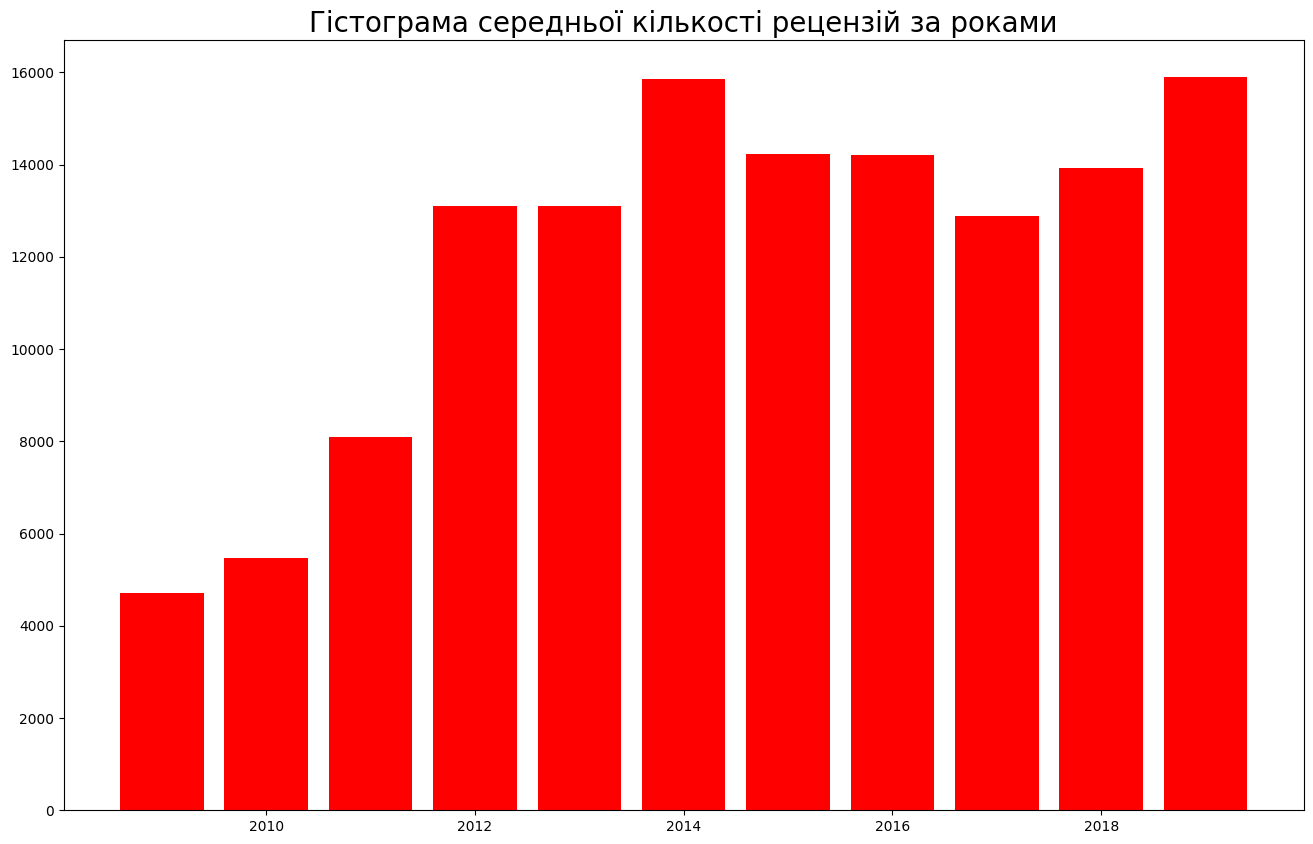

In [30]:
df7 = df.groupBy('Year').agg({'Reviews': 'avg'}).toPandas()

plt.bar(df7['Year'], df7['avg(Reviews)'], color='r' )
plt.title('Гістограма середньої кількості рецензій за роками', fontsize=20, color='black')
plt.show()

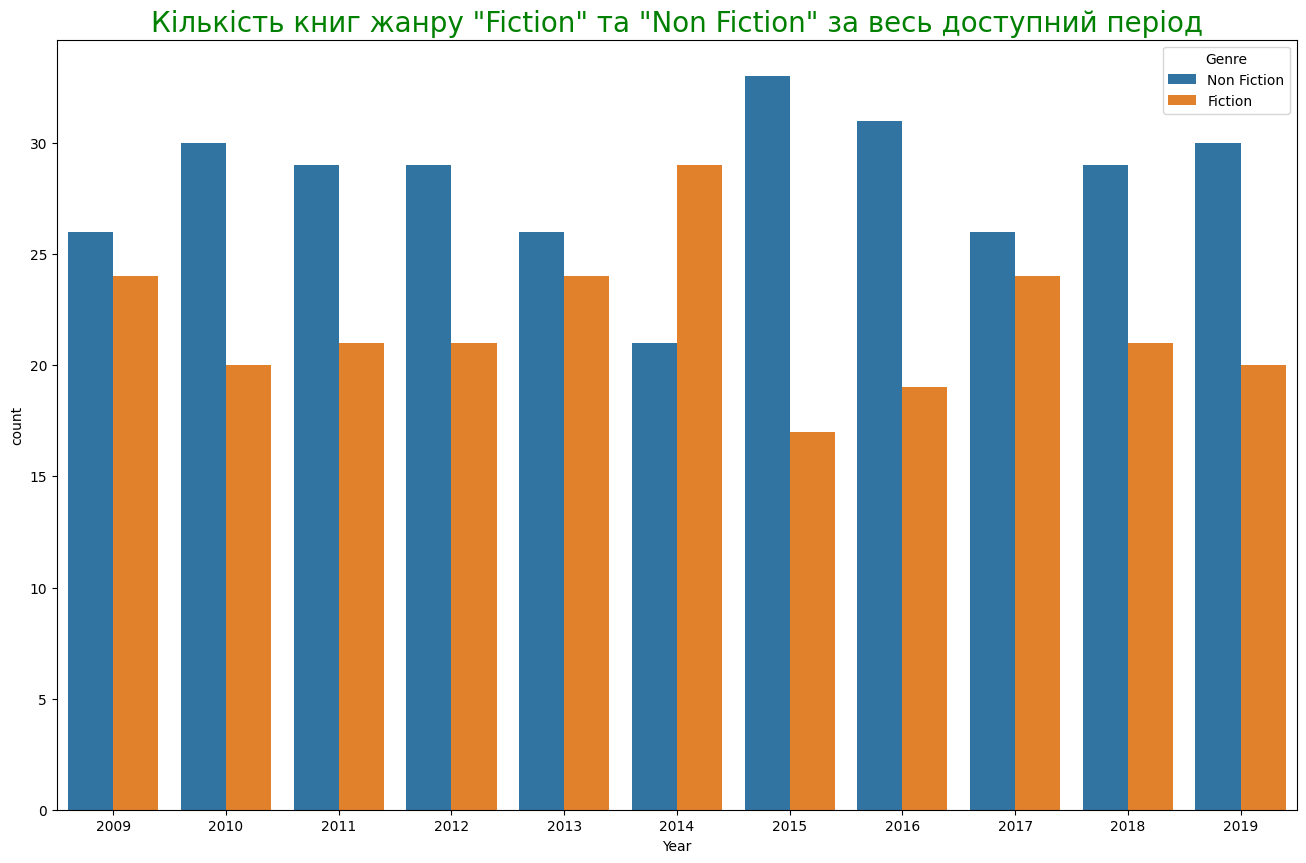

In [38]:
df8 = df.groupby(["Year", "Genre"]).count().toPandas()

sns.barplot(x="Year", y="count", hue="Genre", data=df8)
plt.title('Кількість книг жанру "Fiction" та "Non Fiction" за весь доступний період', fontsize=20, color='g')
plt.show()